### Optimization of 2-D Himmelblaue function for varied coefficients
##### Reference: https://en.wikipedia.org/wiki/Himmelblau%27s_function
$$ cost(a,b,x,y) =  (x^2+y-a)^2 + (x+y^2-b)^2 ,$$
$$pdf(a,b,x,y) = e^{-cost(a,b,x,y)}$$ 

Here, $\mathbf{x}_{task}=(a,b)$ and $\mathbf{x}_{decision} = (x,y)$

Depending on the choice of task-parameters $(a,b)$ there could be several global optima.

We show that TTGO is able to find the multiple global optima consistently with a hand few of samples from the constructed tt-model of the above pdf (constructed offline) for various selection of $\mathbf{x}_{task}=(a,b)$ in the online phase.  We use scipy's SLSQP to fine tune the initialization. 

Condition on different values of $\mathbf{x}_{task}=(a,b)$ to test the model. Watch out for the multimodality in the solutions of TTGO!

Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/
    Written by Suhan Shetty <suhan.shetty@idiap.ch>,


In [1]:
import torch
import numpy as np
import sys
sys.path.append('./fcn_opt')
sys.path.append('../')

from ttgo import TTGO
import tt_utils
from test_fcns import Himmelblaue_4D 
from fcn_plotting_utils import plot_surf, plot_contour

%load_ext autoreload
np.set_printoptions(precision=3)
%autoreload 2

/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-w_m65t3h because the default path (/idiap/home/sshetty/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Define the function

In [51]:
pdf, cost =  Himmelblaue_4D(alpha=0.25)

### Define the domain and the discretization

In [52]:
# Define the domain of the function
L = 5 # [-L,L]^2 is the domain of the function
# domain of task params: domain of coefficients a and b in Himmelblaue 
domain_task = [torch.linspace(1,15,500).to(device)]+[torch.linspace(1,15,500).to(device)] 
# domain of decision variables
domain_decision = [torch.linspace(-L,L,500).to(device)]*2 # domain of x-y coordinates 
domain = domain_task+domain_decision


In [53]:
# Find the tt-model corresponding to the pdf
tt_model = tt_utils.cross_approximate(fcn=pdf,  domain=domain, 
                        rmax=200, nswp=20, eps=1e-3, verbose=True, 
                        kickrank=5, device=device)

cross device is cuda
Cross-approximation over a 4D domain containing 6.25e+10 grid points:
iter: 0  | tt-error: 1.000e+00, test-error:9.918e-01 | time:   0.0362 | largest rank:   1
iter: 1  | tt-error: 2.281e+00, test-error:9.560e-01 | time:   0.0904 | largest rank:   6
iter: 2  | tt-error: 1.423e+00, test-error:8.700e-01 | time:   0.1670 | largest rank:  11
iter: 3  | tt-error: 7.266e-01, test-error:7.745e-01 | time:   0.2539 | largest rank:  16
iter: 4  | tt-error: 6.727e-01, test-error:6.460e-01 | time:   0.4056 | largest rank:  21
iter: 5  | tt-error: 4.207e-01, test-error:5.452e-01 | time:   0.5303 | largest rank:  26
iter: 6  | tt-error: 2.340e-01, test-error:5.004e-01 | time:   0.6742 | largest rank:  31
iter: 7  | tt-error: 2.990e-01, test-error:4.173e-01 | time:   1.0427 | largest rank:  36
iter: 8  | tt-error: 2.154e-01, test-error:3.561e-01 | time:   1.2934 | largest rank:  41
iter: 9  | tt-error: 1.479e-01, test-error:3.089e-01 | time:   1.5687 | largest rank:  46
iter: 10 

### Fit the TT-Model

In [54]:
ttgo = TTGO(tt_model=tt_model,domain=domain,cost=cost, device=device)

In [55]:
# torch.save([ttgo.tt_model,domain],'himmel4D.pickle')

### Sample from TT-Model

In [63]:
a=14; b=2.
x_task = torch.tensor([a,b]).view(1,-1).to(device) #given task-parameters
n_samples_tt = 100
samples = ttgo.sample_tt(n_samples=n_samples_tt, x_task=x_task.view(1,-1), alpha=0.9) 

### Choose the best sample as an estimate for optima

In [64]:
best_estimate = ttgo.choose_best_sample(samples)[0]
top_k_estimate = ttgo.choose_top_k_sample(samples,k=50)[0] # for multiple solutions

##### Fine-tune the estimate using gradient-based optimization

In [65]:
ttgo_optimized, _ = ttgo.optimize(best_estimate)

ttgo_optimized_k = 1*top_k_estimate
for i, x in enumerate(ttgo_optimized_k):
    ttgo_optimized_k[i], _ = ttgo.optimize(x)


In [66]:
print("PDF at the estimated point: ", pdf(best_estimate))
print("PDF at the optima: ", pdf(ttgo_optimized))

PDF at the estimated point:  tensor([0.9952], device='cuda:0')
PDF at the optima:  tensor([1.0000], device='cuda:0')


In [67]:
print("Estimated Optima: ", best_estimate)
print("Optima: ", ttgo_optimized)

Estimated Optima:  tensor([[14.0000,  2.0000, -3.3968,  2.3347]], device='cuda:0')
Optima:  tensor([[13.9972,  2.0021, -3.4154,  2.3278]], device='cuda:0')


### Visualization

In [68]:
# Redefinig the function given the coefficients
def cost_fcn(X):
    X = torch.from_numpy(X)
    X_ext = torch.empty(X.shape[0],4)
    X_ext[:,:2] = x_task
    X_ext[:,2:] = X
    return cost(X_ext.to(device)).cpu().numpy()

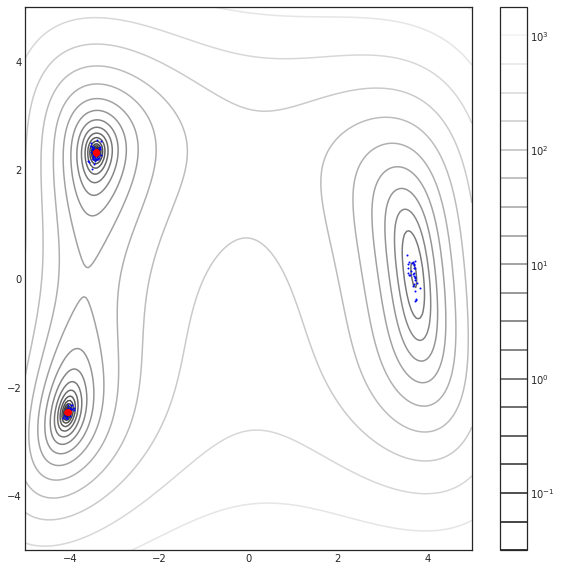

In [69]:
x = np.linspace(-L,L,200)
y = np.linspace(-L,L,200)
data = samples[0,:,2:].cpu()

plt=plot_contour(x,y,cost_fcn,data=data, contour_scale=1000, figsize=10, markersize=1)
# plt.plot(ttgo_optimized[:,2],ttgo_optimized[:,3],'*r',markersize=10)
plt.plot(ttgo_optimized_k[:,2].cpu(),ttgo_optimized_k[:,3].cpu(),'.r',markersize=10)
# plt.legend(["samples","optima"])
# plt.title(r"Himmelblau: $cost=(x^2+y-{})^2+(x+y^2-{})^2$".format(a,b))
# plt.savefig('Himmelblau4D_a13_b5_alpha0_ns1000_k10.png',pad_inches=0.01, dpi=300)
# plt.plot(gott_top_k_estimate[:,2],gott_top_k_estimate[:,3],'*r',markersize=8)